In [1]:
%load_ext autoreload
%autoreload 2
import sys; 
sys.path.append('../../')
import pandas as pd
from PIL import Image
import numpy as np
from tqdm import tqdm
import os
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn as nn
from datetime import date, time, datetime
from sklearn.metrics import f1_score
import copy
import plotly
import pickle
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from skimage import io
from src.model.dataset import VoronoiRegionDataset
from sklearn.model_selection import train_test_split
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #cuda:0
DEVICE
torch.manual_seed(42)

In [2]:
#limit = 500
limit = None
BATCH_SIZE = 20
IMG_SHAPE = [244,244]

In [3]:
train_root = r"../../dl/train"
assert os.path.exists(train_root)
test_root = r"../../dl/test"
assert os.path.exists(train_root)

In [4]:
train_dataset = VoronoiRegionDataset(train_root,limit)
targets = train_dataset.labels

In [5]:
targets

,index,filename,label
0,0,p10_0031_5_0.jpg,2
1,0,p10_0031_5_1.jpg,2
2,0,p10_0031_5_2.jpg,2
3,0,p10_0031_5_3.jpg,1
4,0,p10_0031_5_4.jpg,3
...,...,...,...
75281,0,p9_0244_9_2.jpg,2
75282,0,p9_0245_7_0.jpg,2
75283,0,p9_0245_7_1.jpg,1
75284,0,p9_0245_7_2.jpg,1


In [6]:
train_dataset.__len__()

75286

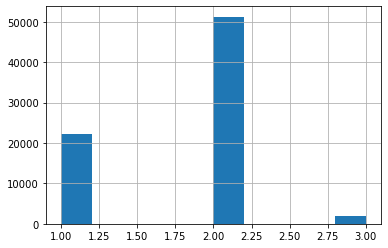

In [7]:
x = train_dataset.__getlabels__().label.hist()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


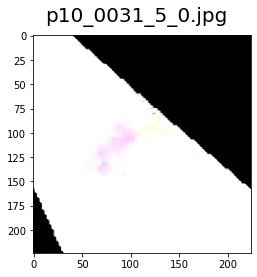

In [19]:
train_idx, valid_idx= train_test_split(
np.arange(len(targets.label)),test_size=0.2,shuffle=True,stratify=targets.label)
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)
train_dataloader = DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,sampler=train_sampler)
test_dataloader = DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,sampler=valid_sampler)
train_dataset.plot(0)

In [9]:
train_dataset.__len__()

75286

In [12]:
from torchvision import datasets, models, transforms

In [16]:
NUM_CLASSES = train_dataset.__get_num_classes__()
model = models.densenet121(pretrained=True)

In [67]:
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, NUM_CLASSES)

In [68]:
model = model.to(DEVICE)


In [69]:
adam = optim.Adam(model.parameters(),lr=0.001)

In [70]:
loss_fnc = nn.CrossEntropyLoss()

In [20]:
dataloaders = {
    'train':train_dataloader,
    'val': test_dataloader
}

In [72]:
def train(model,dataloaders,loss_fnc,optim,epochs):
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_fscore = 0.0
    
    history={
        'acc_train':[],
        'loss_train':[],
        'acc_val':[],
        'loss_val':[],
        'fscore_train':[],
        'fscore_val':[]
    }
    for epoch in tqdm(range(epochs)):
        for phase in ['train','val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            fscore_epoch = []
            for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(DEVICE)
                    labels = labels.to(DEVICE)
                    #print(inputs.shape)
                    optim.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = loss_fnc(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optim.step()
                    running_loss += loss.cpu().item() * inputs.size(0)
                    #
                    running_corrects += torch.sum(preds == labels.data).cpu()
                    predicted_numpy = preds.cpu()
                    predicted_numpy = predicted_numpy.numpy()
                    fscore_epoch.append(f1_score(y_true=labels.cpu().data,y_pred=predicted_numpy,average='macro'))
                    
            epoch_acc = running_corrects/ len(dataloaders[phase].dataset)
            fscore_epoch = sum(fscore_epoch) / len(fscore_epoch)
            history['loss_'+phase].append(running_loss/ len(dataloaders[phase].dataset))
            history['acc_'+phase].append(epoch_acc)
            history['fscore_'+phase].append(fscore_epoch)
            if phase == 'val' and fscore_epoch > best_fscore:
                best_fscore = fscore_epoch
                best_model_wts = copy.deepcopy(model.state_dict())
    model.load_state_dict(best_model_wts)
    return model, history

In [73]:
model_trained, hist = train(model,dataloaders,loss_fnc,adam,17)

100%|██████████████████████████████████████████████████████████████████████████████| 17/17 [4:46:28<00:00, 1011.10s/it]


In [78]:
date = datetime.now()
filename = 'densenet_'+str(date.date())+"_time_"+str(date.time()).split('.')[0].replace(":","_")
torch.save(model_trained.state_dict(),filename)
with open('history_'+filename+'.pickle', 'wb') as f:
    pickle.dump(hist, f)

In [79]:
def plot_history(history_arr,title,y='',x='',tit=''):
    plt.plot(history_arr)
    plt.ylabel(y)
    plt.xlabel(x)
    plt.title(tit) # subplot 211 title
    plt.show()

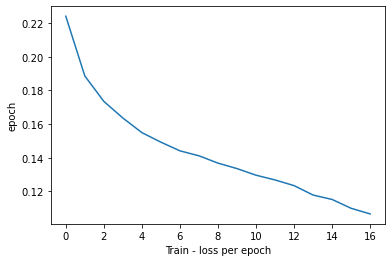

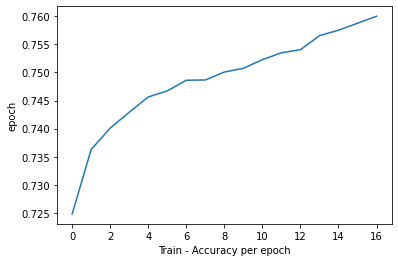

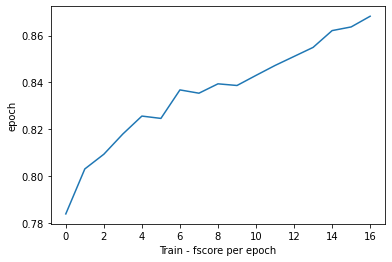

In [80]:
plot_history(hist['loss_train'],'loss','epoch','Train - loss per epoch')
plot_history(hist['acc_train'],'accuracy','epoch','Train - Accuracy per epoch')
plot_history(hist['fscore_train'],'fscore','epoch','Train - fscore per epoch')



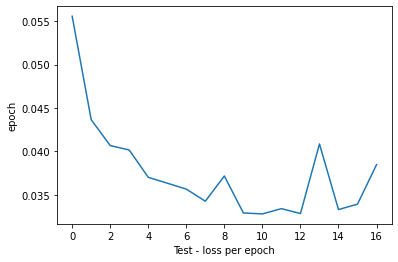

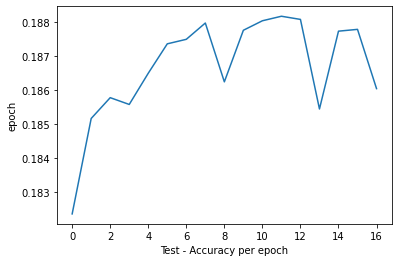

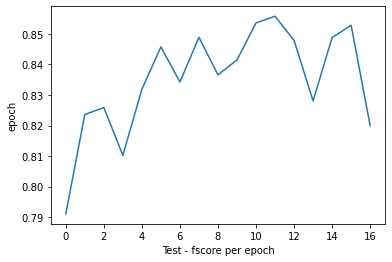

In [82]:
plot_history(hist['loss_val'],'loss','epoch','Test - loss per epoch')
plot_history(hist['acc_val'],'accuracy','epoch','Test - Accuracy per epoch')
plot_history(hist['fscore_val'],'fscore','epoch','Test - fscore per epoch')


In [23]:
from sklearn.metrics import classification_report

In [24]:
MODEL_PATH = "densenet_2021-04-07_time_16_13_46"
model = models.densenet121(pretrained=True)

num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, NUM_CLASSES)
model = model.to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()
for phase in ['train','val']:
    y_true = []
    y_pred = []
    for inputs, labels in tqdm(dataloaders[phase]):
        with torch.set_grad_enabled(False):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_pred.append(preds.cpu().numpy())
            y_true.append(labels.cpu().data.numpy())
    print(f"*****{phase}*******")
    y_pred=  [item for sublist in y_pred for item in sublist]
    y_true=  [item for sublist in y_true for item in sublist]
    print(classification_report(y_true, y_pred))

  0%|                                                                                          | 0/753 [00:00<?, ?it/s]

*****train*******
              precision    recall  f1-score   support

           0       0.95      0.92      0.94     17734
           1       0.95      0.98      0.96     40993
           2       0.72      0.39      0.51      1501

    accuracy                           0.95     60228
   macro avg       0.87      0.76      0.80     60228
weighted avg       0.94      0.95      0.94     60228



100%|████████████████████████████████████████████████████████████████████████████████| 753/753 [01:32<00:00,  8.12it/s]

*****val*******
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      4434
           1       0.95      0.98      0.96     10249
           2       0.74      0.38      0.50       375

    accuracy                           0.95     15058
   macro avg       0.88      0.76      0.80     15058
weighted avg       0.95      0.95      0.95     15058



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


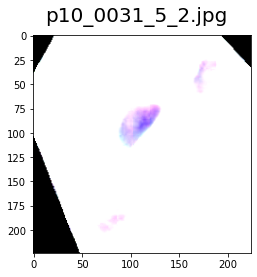

In [27]:
train_dataset.plot(2)